In [1]:
import numpy as np
import pandas as pd
import torch, os, random
from glob import glob
from torch.utils.data import DataLoader, Dataset, random_split
from matplotlib import pyplot as plt
from torchvision import transforms as T
from PIL import Image


In [26]:
class CustomDataset(Dataset):
      
    def __init__(self,root, im_type = ['.png', '.jpg', '.jpeg'], tranformations = None):
        super(). __init__()
        self.im_path = glob(f"{root}/*/*[{ i for i in im_type}]")
        self.tranformations = tranformations
        self.class_dict = {}
        count = 0
        # Create a dictionary (`class_dict`) to map class names to unique indices using the `get_class` function.
        # Iterate over image paths (`paths`) and assign unique indices to each unique class name.
        # If a class name is not already in the dictionary, add it with the current index (`count`) and increment the index counter.
        for idx, paths in enumerate(self.im_path):
            ims = self.get_class(paths)
            if ims not in self.class_dict:
                self.class_dict[ims] = count;
                count+=1

    def get_class(self, path):
        return os.path.dirname(path).split('\\')[-1]
    
    def __len__(self): return len(self.im_path)

    def __getitem__(self, idx):
        image = self.im_path[idx]
        im = Image.open(image).convert("RGB")
        gt = self.class_dict[self.get_class(image)]
        if self.tranformations is not None: im = self.tranformations(im)
        return im, gt
        
tranformer = T.Compose([T.Resize((224, 224)),
                       T.ToTensor()])
root = "Fruits Dataset"
data = CustomDataset(root =root, tranformations = tranformer)
classes = data.class_dict
classes


{'fresh_peaches_done': 0,
 'fresh_pomegranates_done': 1,
 'fresh_strawberries_done': 2,
 'rotten_peaches_done': 3,
 'rotten_pomegranates_done': 4,
 'rotten_strawberries_done': 5}

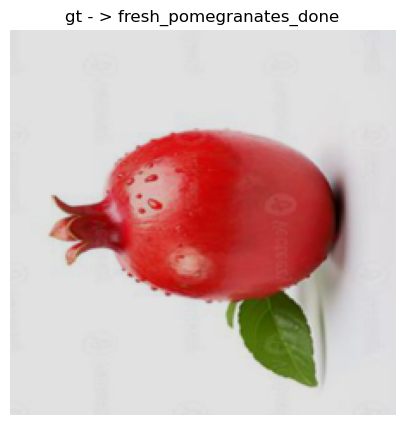

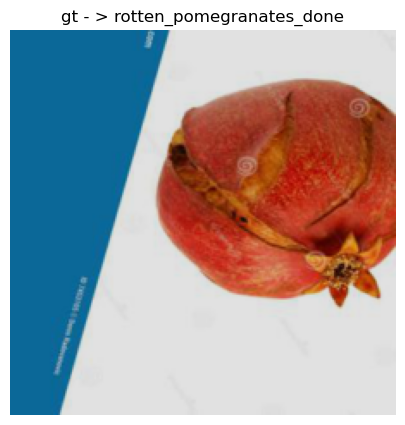

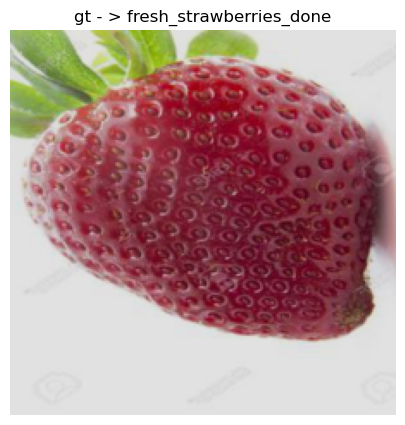

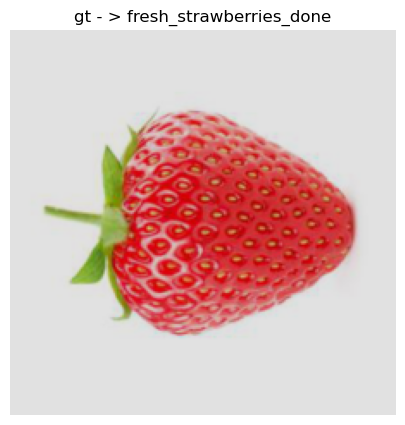

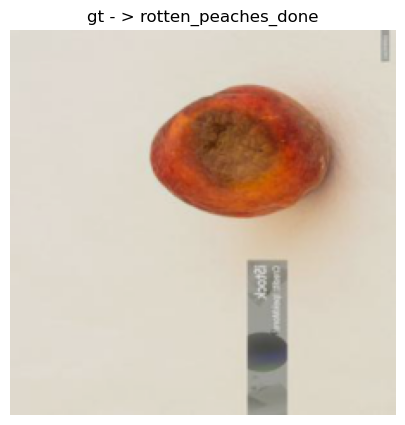

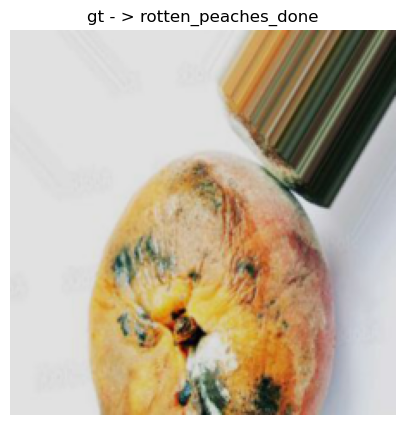

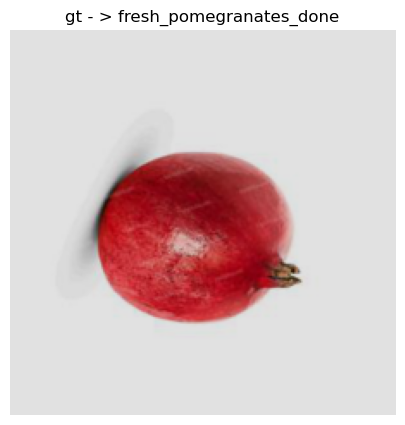

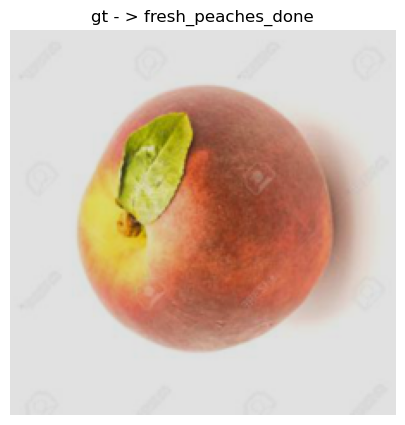

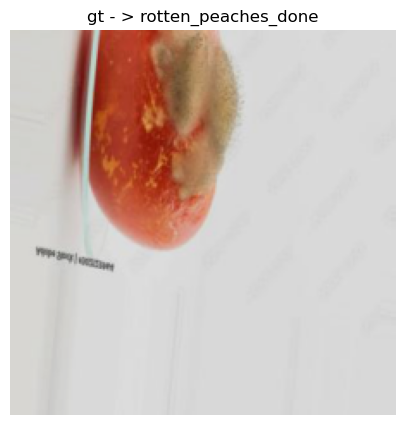

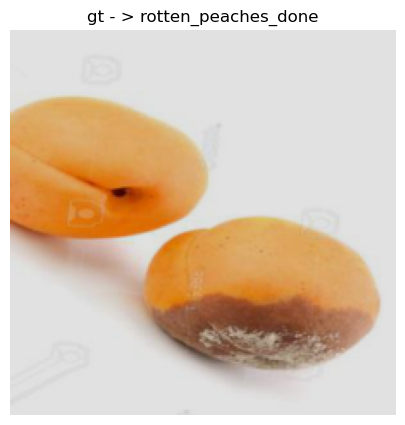

In [27]:
# Vizualization
import random
class_name = list(classes.keys())
data_num = 10
index = [random.randint(0, len(data)-1) for _ in range(data_num)]
for idx, idxs in enumerate(index):
    im, gt = data[idxs]
    plt.figure(figsize=(10,5))
    plt.imshow((im*225).cpu().permute(2,1,0).numpy().astype('uint8'))
    plt.axis("off")
    plt.title(f"gt - > {class_name[gt]}")
    plt.show()
    

In [29]:
data_len = len(data)
split_data = [0.8, 0.1, 0.1]
tr_len = int(data_len*split_data[0])
val_len = int(data_len*split_data[1])
ts_len = (data_len- (tr_len+val_len))

tr_ds, val_ds, ts_ds = random_split(dataset=data, lengths=[tr_len, val_len, ts_len] )
print(tr_len)
print(val_len)
print(ts_len)



1324
165
166


In [31]:
# dataloader
bs = 32
tr_dl = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = 0)
val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = 0)
ts_dl = DataLoader(dataset = ts_ds, batch_size = bs, shuffle = False, num_workers = 0)

print(len(tr_dl))
print(len(val_dl))
print(len(ts_dl))


42
6
6


In [38]:
import timm
model = timm.create_model(model_name='rexnet_200', pretrained=True, num_classes = len(classes))
loss_fn = torch.nn.CrossEntropyLoss()
optimazer = torch.optim.SGD(params=model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else "cpu"
model.to(device)

RexNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (features): Sequential(
    (0): LinearBottleneck(
      (conv_dw): ConvNormAct(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
      (act_dw): ReLU6()
      (conv_pwl): ConvNormAct(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
    )
    (1): LinearBottlene

In [39]:
from tqdm import tqdm
def train( model, train_data, val_data, loss_fn, opt, epochs, save_prefix, threshold):
    tr_acc_sc, tr_epochs_loss, val_acc_sc, val_epochs_loss = [],[],[],[]
    best_epochs_loss = np.inf
    print("Train progress is starting .......")
    
    for epoc in range(epochs):
        print(f"{epoc+1} - epoc train starting")
        tr_acc, tr_loss, tr_total =0,0,0
        
        for indx, batch in enumerate(tqdm(train_data)):
            im, gt = batch
            im, gt = im.to(device), gt.to(device) 
            pred = model(im)
            loss = loss_fn(pred, gt)
            tr_loss+=loss.item()
            pred_class = torch.argmax(pred, dim=1)
            tr_acc+=(pred_class==gt).sum().item()
            tr_total+=im.shape[0]

            # perform optimization accurancy
            opt.zero_grad()
            loss.backward()
            opt.step()
        tr_acc /=tr_total
        tr_loss /= len(train_data)
        
        tr_acc_sc.append(tr_acc)
        tr_epochs_loss.append(tr_loss)
        
        model.eval()
        with torch.no_grad():
            val_acc, val_loss, val_total = 0,0,0
            for idx, batch in enumerate(tqdm(val_data)):
                im, gt = batch
                im, gt = im.to(device), gt.to(device)
                pred = model(im)
                loss = loss_fn(pred, gt)
                val_loss+=loss.item()
                pred_class = torch.argmax(pred, dim =1)
                val_acc+=(pred_class == gt).sum().item()
                val_total+=im.shape[0]
                
            val_acc/= val_total
            val_loss/= len(val_data)
            
            val_acc_sc.append(val_acc)
            val_epochs_loss.append(val_loss)

            print(f"{epoc+1} - epoc Train process is fineshed\n")
            print(f"{epoc+1} - epoc Train Accurancy score     - > {tr_acc:.3f}")
            print(f"{epoc+1} - epoc Train loss score          - > {tr_loss:.3f}\n")
            
            print(f"{epoc+1} - epoc Validation process is fineshed\n")
            print(f"{epoc+1} - epoc Validation Accurancy score - > {val_acc:.3f}")
            print(f"{epoc+1} - epoc Valisation epoc loss score - > {val_loss:.3f}")

                        
            if val_loss < (best_epochs_loss+threshold):
                val_loss = best_epochs_loss
                os.makedirs("fruits_best_model", exist_ok = True)
                torch.save( model, f"fruits_best_model/{save_prefix}_best_model.pht")
                
    return {"tr_acc_sc": tr_acc_sc, "tr_epochs_loss": tr_epochs_loss, "val_acc_sc": val_acc_sc, "val_epochs_loss": val_epochs_loss}            
        
result = train(model = model.to(device), train_data=tr_dl, val_data = val_dl, loss_fn=loss_fn, opt = optimazer, epochs=10, save_prefix="fruits", threshold= 0.001)  
     

Train progress is starting .......
1 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.47it/s]


1 - epoc Train process is fineshed

1 - epoc Train Accurancy score     - > 0.314
1 - epoc Train loss score          - > 2.820

1 - epoc Validation process is fineshed

1 - epoc Validation Accurancy score - > 0.455
1 - epoc Valisation epoc loss score - > 1.539
2 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.87it/s]


2 - epoc Train process is fineshed

2 - epoc Train Accurancy score     - > 0.625
2 - epoc Train loss score          - > 1.135

2 - epoc Validation process is fineshed

2 - epoc Validation Accurancy score - > 0.770
2 - epoc Valisation epoc loss score - > 0.508
3 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.27it/s]


3 - epoc Train process is fineshed

3 - epoc Train Accurancy score     - > 0.814
3 - epoc Train loss score          - > 0.514

3 - epoc Validation process is fineshed

3 - epoc Validation Accurancy score - > 0.806
3 - epoc Valisation epoc loss score - > 0.505
4 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.20it/s]


4 - epoc Train process is fineshed

4 - epoc Train Accurancy score     - > 0.863
4 - epoc Train loss score          - > 0.377

4 - epoc Validation process is fineshed

4 - epoc Validation Accurancy score - > 0.739
4 - epoc Valisation epoc loss score - > 0.655
5 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.43it/s]


5 - epoc Train process is fineshed

5 - epoc Train Accurancy score     - > 0.870
5 - epoc Train loss score          - > 0.382

5 - epoc Validation process is fineshed

5 - epoc Validation Accurancy score - > 0.873
5 - epoc Valisation epoc loss score - > 0.346
6 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.22it/s]


6 - epoc Train process is fineshed

6 - epoc Train Accurancy score     - > 0.947
6 - epoc Train loss score          - > 0.165

6 - epoc Validation process is fineshed

6 - epoc Validation Accurancy score - > 0.921
6 - epoc Valisation epoc loss score - > 0.205
7 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.31it/s]


7 - epoc Train process is fineshed

7 - epoc Train Accurancy score     - > 0.971
7 - epoc Train loss score          - > 0.107

7 - epoc Validation process is fineshed

7 - epoc Validation Accurancy score - > 0.885
7 - epoc Valisation epoc loss score - > 0.197
8 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.12it/s]


8 - epoc Train process is fineshed

8 - epoc Train Accurancy score     - > 0.989
8 - epoc Train loss score          - > 0.057

8 - epoc Validation process is fineshed

8 - epoc Validation Accurancy score - > 0.927
8 - epoc Valisation epoc loss score - > 0.185
9 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.20it/s]


9 - epoc Train process is fineshed

9 - epoc Train Accurancy score     - > 0.999
9 - epoc Train loss score          - > 0.034

9 - epoc Validation process is fineshed

9 - epoc Validation Accurancy score - > 0.909
9 - epoc Valisation epoc loss score - > 0.221
10 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.31it/s]


10 - epoc Train process is fineshed

10 - epoc Train Accurancy score     - > 0.999
10 - epoc Train loss score          - > 0.025

10 - epoc Validation process is fineshed

10 - epoc Validation Accurancy score - > 0.927
10 - epoc Valisation epoc loss score - > 0.164


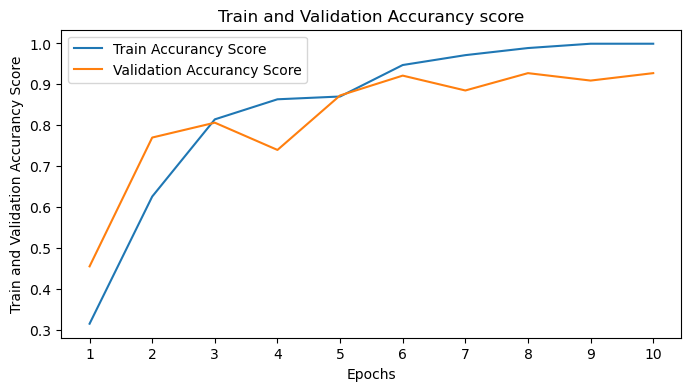

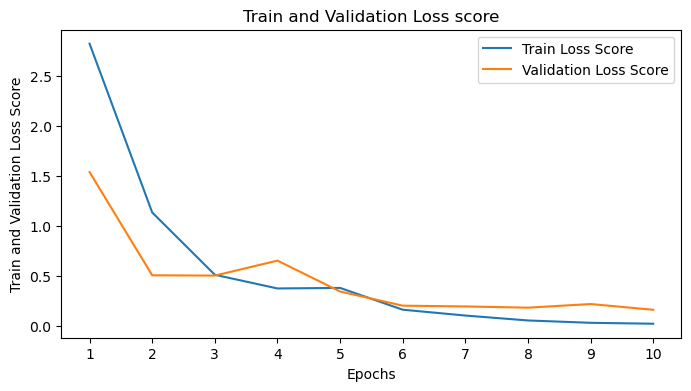

In [43]:
def plot(res):
    
    plt.figure(figsize=(8, 4))
    plt.plot(res["tr_acc_sc"], label = "Train Accurancy Score" )
    plt.plot(res["val_acc_sc"], label = "Validation Accurancy Score")
    plt.title("Train and Validation Accurancy score")
    plt.xlabel("Epochs")
    plt.xticks(np.arange(len(res["val_acc_sc"])), [i for i in range(1, len(res["val_acc_sc"])+1)])
    plt.ylabel("Train and Validation Accurancy Score")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(res["tr_epochs_loss"], label = "Train Loss Score" )
    plt.plot(res["val_epochs_loss"], label = "Validation Loss Score")
    plt.title("Train and Validation Loss score")
    plt.xlabel("Epochs")
    plt.xticks(np.arange(len(res["val_acc_sc"])), [i for i in range(1, len(res["val_acc_sc"])+1)])
    plt.ylabel("Train and Validation Loss Score")
    plt.legend()
    plt.show()
    
plot(result)

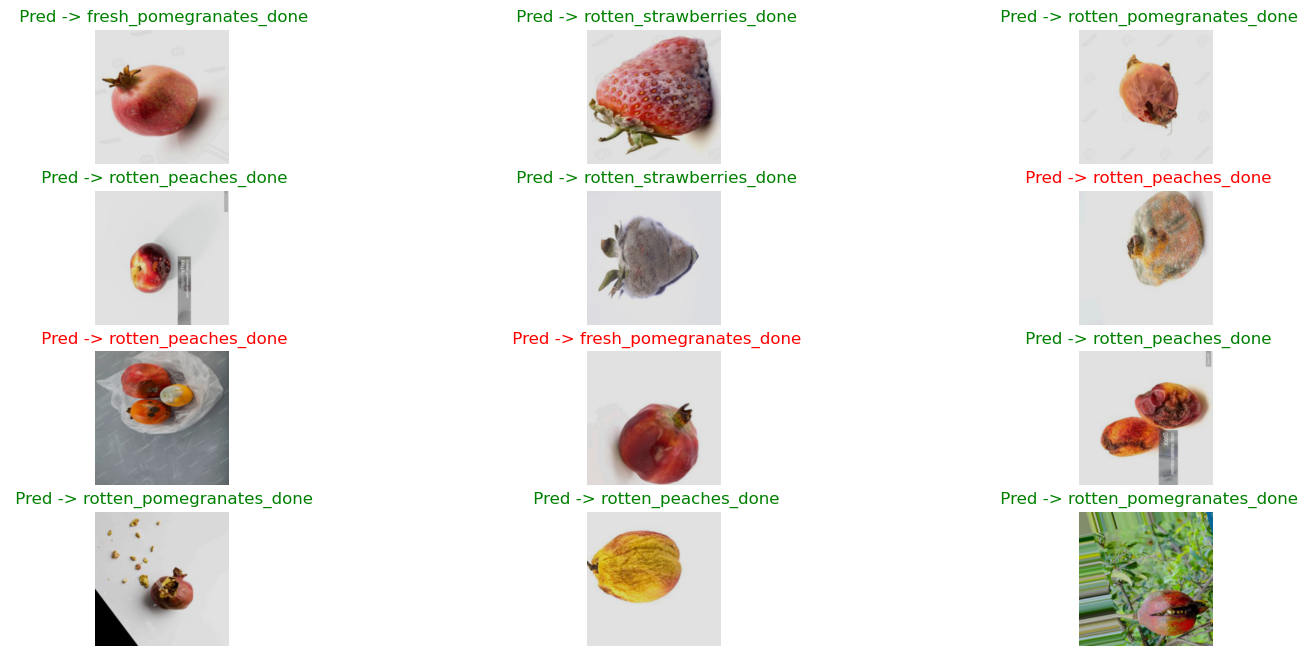

In [49]:
import torch
import matplotlib.pyplot as plt

def inference(data, model, device, number_im, images_per_row, class_name=None):
    ims, preds = [], []
    for idx, batch in enumerate(data):
        if idx == number_im:
            break
        im = batch
        ims.append(im)
        pred = torch.argmax(model(im[0].unsqueeze(dim=0).to(device)), dim=1).item()
        preds.append(pred)

    plt.figure(figsize=(18, 8))
    for row in range(0, number_im, images_per_row):
        for cal in range(images_per_row):
            index = cal + row
            if index < number_im:
                im = ims[index]
                plt.subplot(number_im // images_per_row, images_per_row, index + 1)
                plt.imshow((im[0].cpu() * 225).permute(2, 1, 0).numpy().astype("uint8"))
                plt.axis("off")
                if class_name is not None:
                    title_color = 'green' if class_name[preds[index]] == class_name[im[1]] else 'red'
                    plt.title(f" Pred -> {class_name[preds[index]]}", color=title_color)
                else:
                    plt.title(f"Prediction: {preds[index]}")
    plt.show()

# Assuming you have defined classlar and ts_ds
model = torch.load("fruits_best_model/fruits_best_model.pht")
inference(data=ts_ds, model=model.to(device), device=device, number_im=12, class_name=list(classes.keys()), images_per_row=3)
